# Pairing Trading 

Pair trading is a **market-neutral trading strategy** that involves simultaneously taking a long position and short position in different co-related stocks. The goal is to earn on the relative price movements between the two assets while minimising overall market risk. This approach relies on the assumption that the prices of the two correlated assets will eventually revert to their historical relationship, allowing the trader to profit from the convergence or divergence of their prices.

![image info](SP.png)


# Steps breakdown

1. Identification of two co-related stocks from the ```NSE/BSE(Indian stocks)```
2. Implementing the trading strategy to calculate the returns from the spread
3. Backtesting the strategy on various factors (profitability, risk adjusted returns and consistency)
4. Optimizing the parameters to increase returns and enhance robustness.
5. Final Report on the strategy based on historical data 


In [94]:
# Import necessary libraries
import numpy as np              # Library for numerical operations
import matplotlib.pyplot as plt # Plotting library
import pandas as pd             # Data manipulation library
import yfinance as yf           # Library to fetch financial data
import statsmodels.api as sm    # Statistical models and tests
import warnings                 # Manage warnings in Python
import seaborn as sn            # Statistical data visualization
from matplotlib.pyplot import figure  # Additional plotting functionalities


# Identification of two Stocks

The following steps can procedded for this :=> 

- Collection of data from yfinance and NSE listed companies
	> To download CSV https://www.nseindia.com/regulations/listing-compliance/nse-market-capitalisation-all-companies
	
- Fetching the closing prices of the top 100 companies listed on the NSE. 
---
# Selecting the pairs

- To avoid the inefficiency of analyzing all possible combinations of over 2,380 companies at once, we should implement an initial filtering step to select only 2 companies based on same sectors.

- Building a Test for Co-integration , Corelation and Zscore and giving a final score for checking the robustness of two pairs

- Spread is mean-reverting by checking its stationarity using the Augmented Dickey-Fuller (ADF) test on the spread

In [131]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="The 'unit' keyword in TimedeltaIndex construction is deprecated")

# Importing necessary libraries
import pandas as pd             # Data manipulation library
import yfinance as yf           # Library to fetch financial data

# Read the CSV file containing company symbols
df = pd.read_csv('NSE.csv')

# Extract symbols of IT sector companies from the DataFrame
comp = df['Symbol']

# Select specific IT sector company symbols
name = [comp[206], comp[167], comp[62], comp[49], comp[32], comp[1], comp[130], comp[6], comp[12], comp[135]]

# Fetch historical stock data for IT sector companies
it_sector = []
for i in name:
    hist = yf.Ticker(i + '.NS')  # Fetch data from Yahoo Finance for each symbol
    a = hist.history(start='2019-01-01', end='2020-01-01')  # Historical data from 2019-01-01 to 2020-01-01
    a['Close'].name = i  # Rename the 'Close' column to the stock symbol
    it_sector.append(a['Close'])  # Append the 'Close' prices to the list for each company


# The Correlation Coefficient

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)


---

The correlation coefficient measures the extent to which the relationship between two variables is linear. Its value is always between -1 and 1. A positive coefficient indicates that the variables are directly related, i.e. when one increases the other one also increases. A negative coefficient indicates that the variables are inversely related, so that when one increases the other decreases. The closer to 0 the correlation coefficient is, the weaker the relationship between the variables.

The correlation coefficient of two series $X$ and $Y$ is defined as
$$r = \frac{Cov(X,Y)}{std(X)std(Y)}$$
where $Cov$ is the covariance and $std$ is the standard deviation.

Two random sets of data will have a correlation coefficient close to 0:


For pair trading let us set the threshold to 0.8

In [132]:
#Function for calculating co-relation between two numpy arrays
def Calculate_Corr(X,Y):
    return np.corrcoef(X,Y)[1,0]

#Just a sample test case to determine Correlation
X = it_sector[6]
Y = it_sector[2]
Calculate_Corr(X,Y)

#Calculating co-relation test between Reliance and TCS

0.7079049112602287

In [133]:
# Calculate the correlation matrix between IT sector companies' stock prices
corr_matrix = np.corrcoef(it_sector)

# Extract names of the companies from their stock price series
names = [it_sector[i].name for i in range(0, len(it_sector))]

<Axes: >

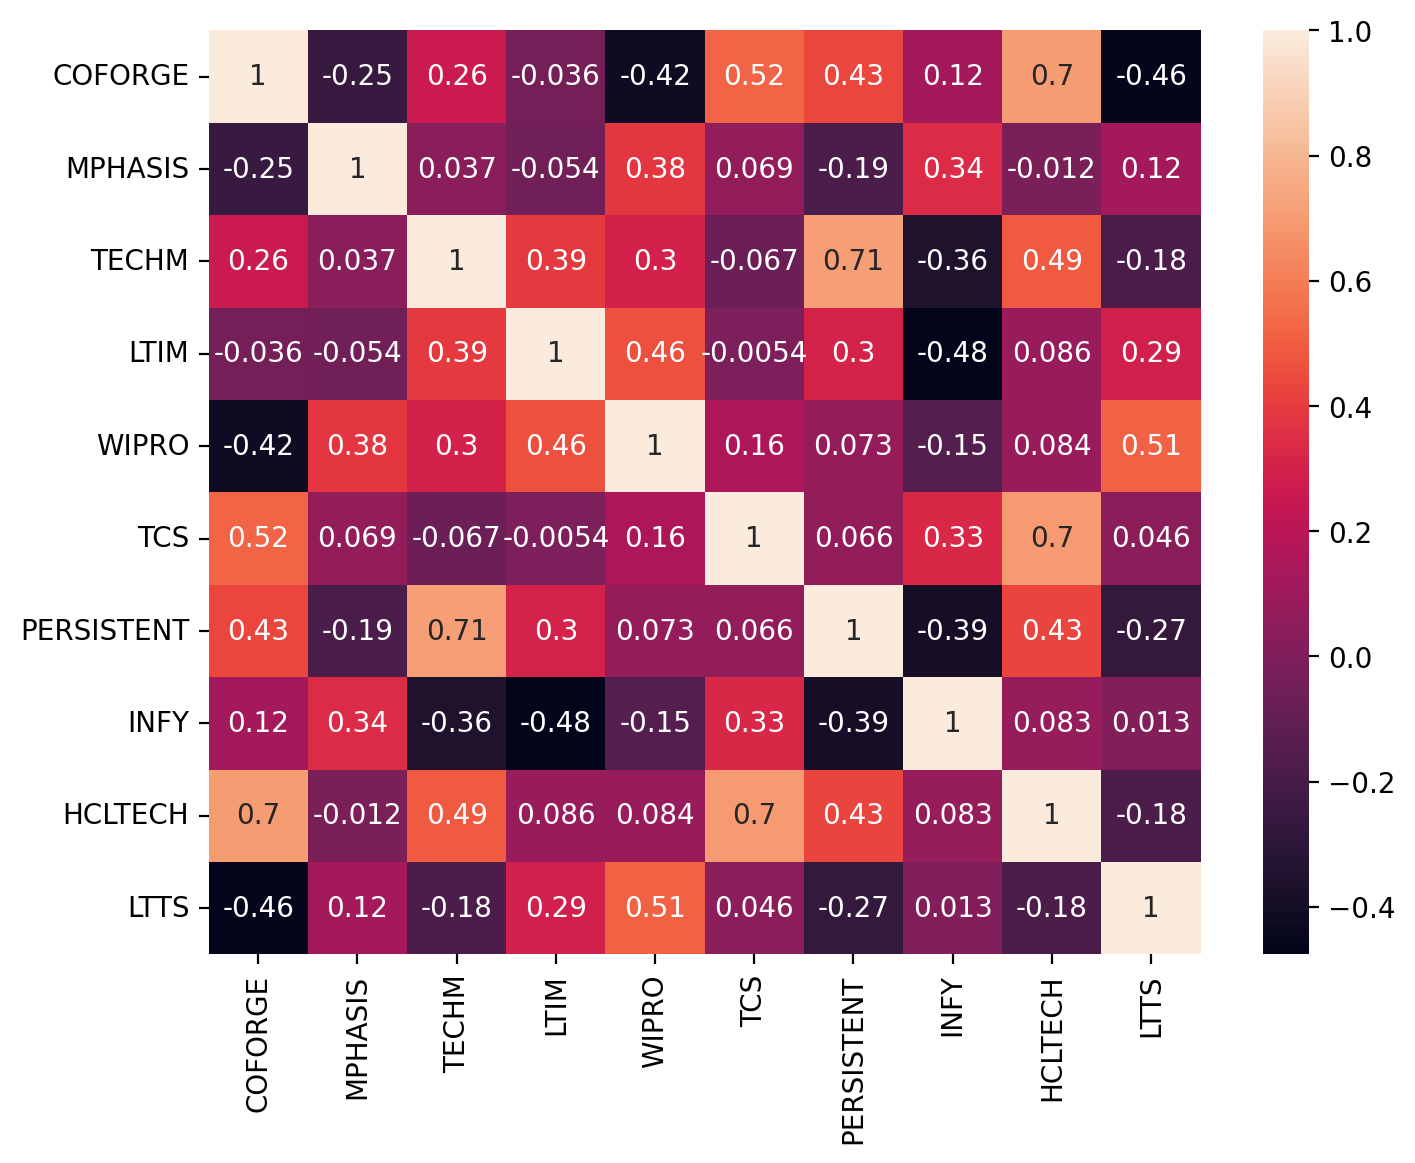

In [134]:

plt.figure(figsize=(8, 6), dpi=200)  # Set the figure size and DPI for better resolution
sn.heatmap(corr_matrix, annot = True,xticklabels=names,yticklabels=names)


## Cointegration

Finally, now that we've discussed stationarity and order of integration, we can discuss cointegration.

---
### Def: Linear Combination

A linear combination of the time series ($X_1$, $X_2$, $\dots$, $X_k$) is a new time series $Y$ constructed as follows for any set of real numbers $b_1 \dots b_k$

$$Y = b_1X_1 + b_2X_2 + \dots + b_kX_k$$

### Formal Definition

The formal definition of cointegration is as follows.


For some set of time series ($X_1$, $X_2$, $\dots$, $X_k$), if all series are $I(1)$, and some linear combination of them is $I(0)$, we say the set of time series is cointegrated.

#### Example

$X_1$, $X_2$, and $X_3$ are all $I(1)$, and $2X_1 + X_2 + 0X_3 = 2X_1 + X_2$ is $I(0)$. In this case the time series are cointegrated.

### Intuition

The intuition here is that for some linear combination of the series, the result lacks much auto-covariance and is mostly noise. This is useful for cases such as pairs trading, in which we find two assets whose prices are cointegrated. Since the linear combination of their prices $b_1A_1 + b_2A_2$ is noise, we can bet on the relationship $b_1A_1 + b_2A_2$ mean reverting and place trades accordingly. See the Pairs Trading Lecture in the [Quantopian Lecture Series](https://www.quantopian.com/lectures) for more information.

In [135]:
min_corr = 0.6
#Deciding the threshold value of minimum correlation between any two stocks

In [138]:
from statsmodels.tsa.stattools import coint
#Function for calculating co-integration between two numpy arrays

def Calculate_Cointegration(X,Y):
    score, pvalue, _ = coint(X,Y)
    return pvalue    

X = it_sector[6]
Y = it_sector[2]

#Calculate the pvalue for two stock vectors(p < 0.05)
print(Calculate_Cointegration(X,Y))

0.08668896991150615


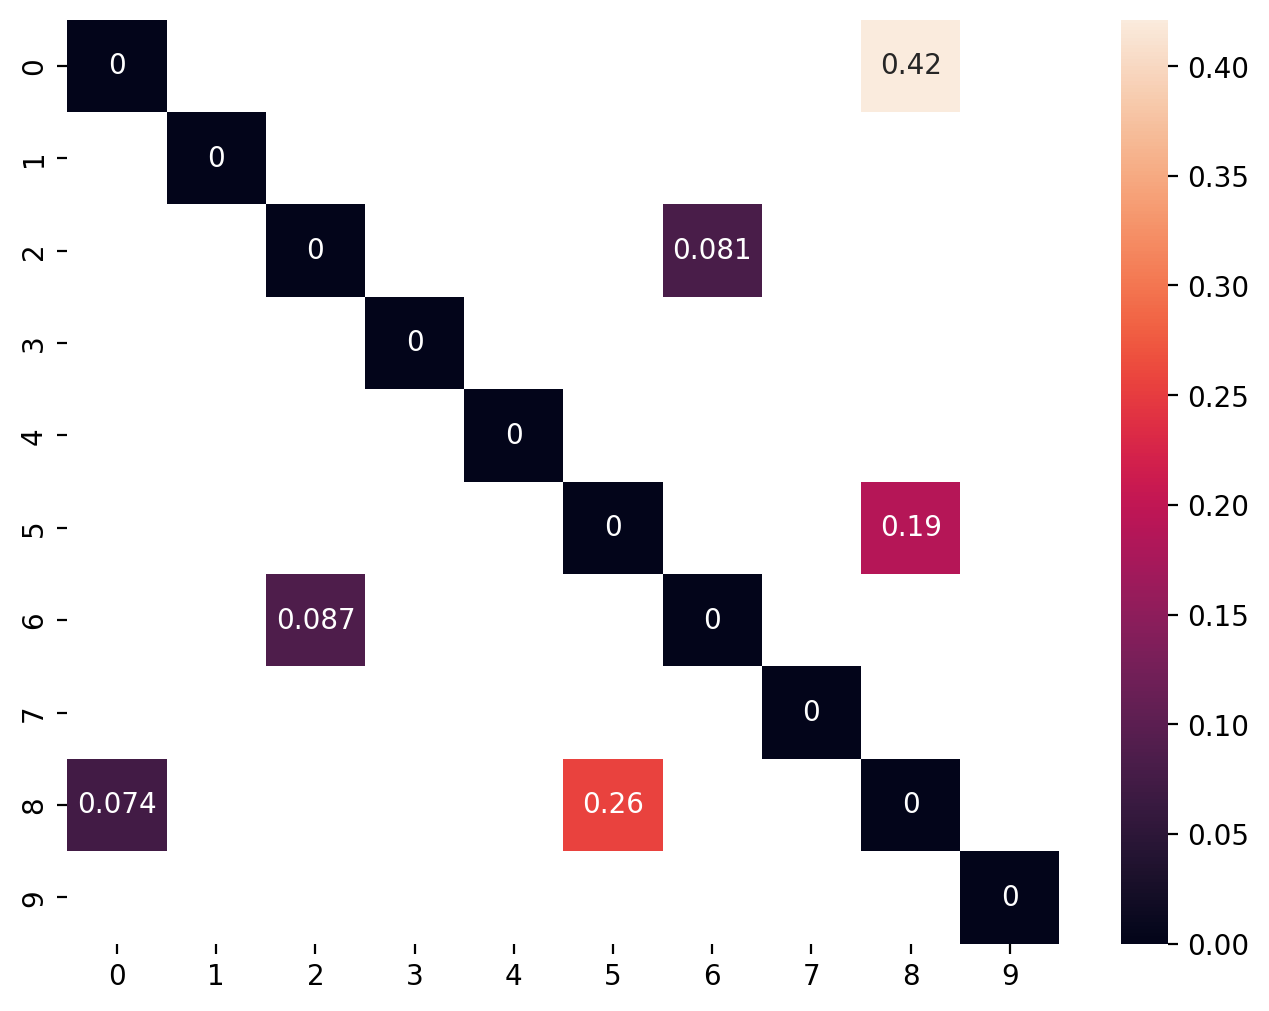

In [137]:
coi_matrix = corr_matrix.copy()
for i in range(0,len(corr_matrix)):
    for j in range(0,len(corr_matrix[0])):
        if i != j:
            #Just analyzing those stocks with corr greater than min_corr(0.6)
            if(corr_matrix[i][j] > min_corr):
                coi_matrix[i][j] = Calculate_Cointegration(it_sector[i],it_sector[j])
            #Else setting the value of that matrix to None
            else:
                coi_matrix[i][j] = None
        else:
            coi_matrix[i][j] = 0

#Now plotting the figure for calculating co-integration ensure that co-int < 0.1
figure(figsize=(8, 6), dpi=200)
sn.heatmap(coi_matrix, annot = True);

# Stationary/Non stationary 
---
A commonly untested assumption in time series analysis is the stationarity of the data. Data are stationary when the parameters of the data generating process do not change over time. As an example, let's consider two series, A and B. Series A is generated from a stationary process with fixed parameters, series B is generated with parameters that change over time.

Stationary data is crucial in pair trading because the main idea behind this strategy is mean reversion. If the spread between two stocks is not stationary and changes over time, the strategy may not consistently work. When the spread is a function of time, it implies that the mean-reverting property is not stable, making it difficult to predict and trade on the reversion reliably. Thus, ensuring the spread is stationary is key to the success of pair trading.

In [141]:
from statsmodels.tsa.stattools import coint, adfuller

def check_for_stationarity(X, cutoff=0.05):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print ('p-value = ' + str(pvalue) + ' The series is likely stationary.')
        return True
    else:
        print ('p-value = ' + str(pvalue) + ' The series is likely non-stationary.')
        return False
    
check_for_stationarity(Y- 1.3718448073406406*X)

p-value = 0.02429841576437994 The series is likely stationary.


True

# Implementing the trading strategy
---
Calculating the Spread
To plot the spread between two series, we will use the Engle-Granger method. This involves performing a linear regression to determine the coefficient for the linear combination of the two stocks. This coefficient helps us calculate the spread accurately.

The value of linear regression constant is -  1.3718448073406406


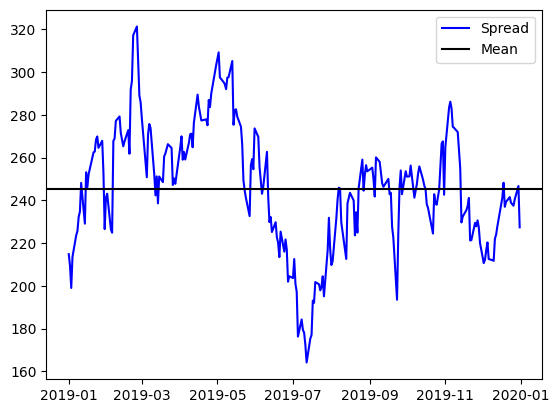

In [140]:
X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
X = X[it_sector[6].name]
b = results.params[it_sector[6].name]

spread = Y-b*X
plt.plot(spread,color = 'blue')
plt.axhline(spread.mean(),color = 'black')
plt.legend(['Spread','Mean']);
print('The value of linear regression constant is - ' , b)

## Z-Score Function

### Definition

The Z-score is a statistical measure that describes a value's relationship to the mean of a group of values. It is measured in terms of standard deviations from the mean. The formula for calculating the Z-score is:
$$
 \text{Z-score} = \frac{(X - \mu)}{\sigma} 
$$
where:
- \( X \) is the value being measured.
- ($ \mu $ )is the mean of the sample.
- \( $\sigma $) is the standard deviation of the sample.

### Uses

1. **Normalization**: Z-scores are used to normalize data. By converting different data points into a common scale, comparisons between different datasets become easier and more meaningful.


5. **Standardization**: Z-scores are used to standardize scores on different scales. For example, test scores from different exams can be standardized to compare student performance across different tests.


In [142]:
def zscore(X):
    return (X - np.mean(X))/np.std(X)

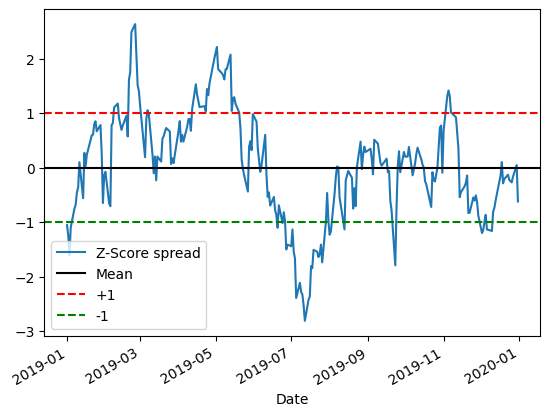

In [143]:
#plotting the zscore plot of spread
zscore(spread).plot()
plt.axhline(0.0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Z-Score spread', 'Mean', '+1', '-1']);

## Explanation of Moving Average and Z-Score Calculation

---
In the provided Python code snippet, we analyze a variable named `spread` using moving averages and calculating a Z-score.

### Moving Averages Calculation

1. **Moving Average with Window Size 5 (`spread_mvg5`):**
   - This line calculates a simple moving average of the `spread` variable over a window of 5 data points. A moving average smooths out short-term fluctuations and highlights longer-term trends in the data.

2. **Moving Average with Window Size 20 (`spread_mvg20`):**
   - Similarly, this calculates another moving average of `spread` but over a wider window of 20 data points. This moving average tends to show an even smoother trend over a longer period compared to `spread_mvg5`.

### Standard Deviation Calculation

3. **Standard Deviation with Window Size 20 (`spread_std`):**
   - Here, the code calculates the rolling standard deviation of `spread` over a window of 20 data points. This standard deviation provides a measure of the volatility or dispersion of `spread` over time.

### Z-Score Calculation

4. **Z-Score of Moving Averages (`zscore_20_5`):**
   - The Z-score is computed as `(spread_mvg5 - spread_mvg20) / spread_std`. It measures how many standard deviations a data point (`spread_mvg5 - spread_mvg20`) is away from the mean (`spread_mvg20`) in the context of the volatility (`spread_std`).

### Plotting the Data

5. **Visualization:**
   - The final part of the code snippet uses a plotting library (`matplotlib`) to visualize the original `spread` data along with its moving averages (`spread_mvg5` and `spread_mvg20`). Legends are added to differentiate between the original data and the moving averages.


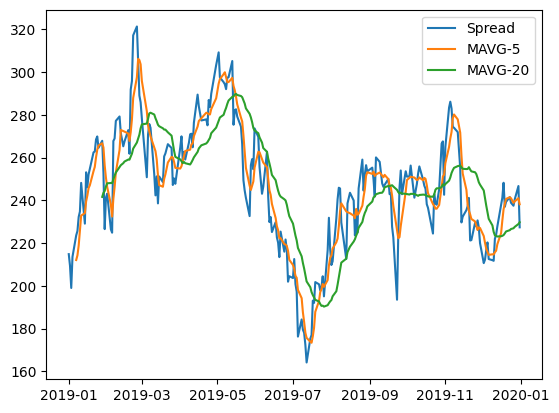

In [144]:
spread_mvg5 = spread.rolling(window = 5).mean()
spread_mvg20 = spread.rolling(window = 20).mean()
spread_std = spread.rolling(window = 20).std()
zscore_20_5 = (spread_mvg5 - spread_mvg20)/spread_std

plt.plot(spread)
plt.plot(spread_mvg5)
plt.plot(spread_mvg20)
plt.legend(['Spread','MAVG-5','MAVG-20']);


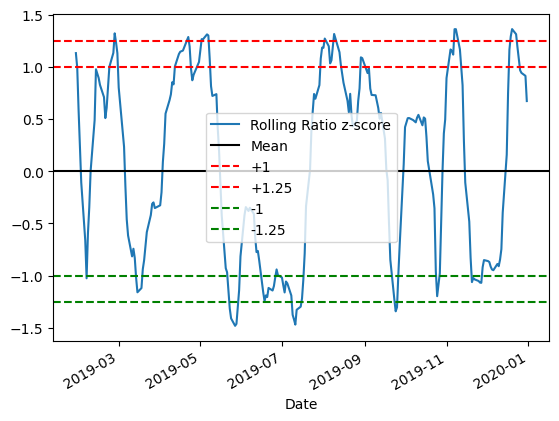

In [145]:
zscore_20_5.plot()
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(1.25, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(-1.25, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-score', 'Mean', '+1','+1.25','-1','-1.25'])
plt.show()

### Strategy Overview
---
Pairs trading involves trading two related securities simultaneously based on their historical relationship. The Z-score helps us determine when the spread between the two securities deviates from its mean, suggesting potential opportunities for buying or selling.

### Implementation Steps

- ***Calculate Z-Score***:   Compute the Z-score of the spread between two assets using moving averages.
- ***Generate Buy and Sell Signals***:  Create positions based on the Z-score thresholds (+1 for sell and -1 for buy).
- ***Plot Buy and Sell Positions***:    Visualize the buy and sell signals on a plot of the spread.

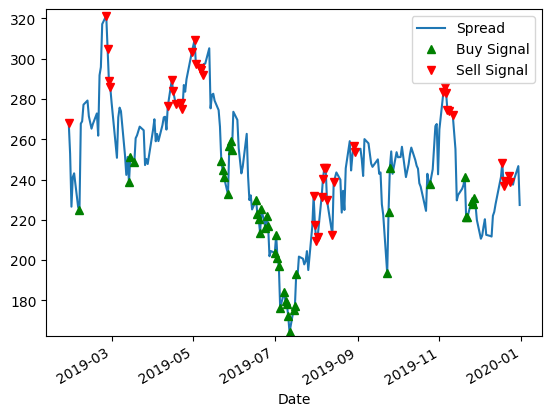

In [146]:
fspread = spread.iloc[19:]
buy = fspread.copy()
sell = fspread.copy()
exit = fspread.copy()


zscore_spread = zscore_20_5.iloc[19:]

plt.plot(fspread)

#Creating all the non buys signals to 0 which initiate all BUY signals to non Zero plotting them on graph
buy[zscore_spread > -1] = 0
sell[zscore_spread < 1] = 0

buy.plot(linestyle = 'none',marker = '^',color = 'g')
sell.plot(linestyle = 'none',marker = 'v',color ='r')

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, 0.99*spread.min(), spread.max()*1.01))
plt.legend(['Spread', 'Buy Signal', 'Sell Signal']);



# Importance of Filtering Points in Trading Strategies
---
Filtering out points where the Z-score exceeds thresholds like -1 or +1 only once is crucial in trading strategies. It helps avoid over-trading, focuses on significant market movements, reduces noise in signals, and enhances strategy effectiveness. This approach ensures that trading decisions are based on meaningful signals, improving overall performance and risk management alignment.


In [149]:
# Convert buy signals to binary (1 if buy, 0 otherwise)
binary_buy = buy.apply(lambda x: 1 if x != 0 else 0)

# Convert sell signals to binary (-1 if sell, 0 otherwise)
binary_sell = sell.apply(lambda x: -1 if x != 0 else 0)

# Initialize position series with buy signals
pos = binary_buy.copy()

# Adjust positions based on sell signals
for i in range(0, len(pos)):
    if binary_sell.iloc[i] == -1:  # If there is a sell signal
        pos.iloc[i] = -1  # Set position to sell (-1)

# Initialize current position state
currentPos = 0

# Adjust positions based on current and previous signals
for i in range(0, len(pos)):
    if currentPos != -1 and pos.iloc[i] == -1:  # If switching to sell
        currentPos = -1  
        pos.iloc[i] = -1 
    elif currentPos == -1 and pos.iloc[i] == -1:  # If continuing to be in sell
        pos.iloc[i] = None  
    elif currentPos != 1 and pos.iloc[i] == 1:  # If switching to buy
        currentPos = 1 
        pos.iloc[i] = 1  
    elif currentPos == 1 and pos.iloc[i] == 1:  # If continuing to be in buy
        pos.iloc[i] = None 
    else:
        pos.iloc[i] = None  # Any other cases set position to None (no action)

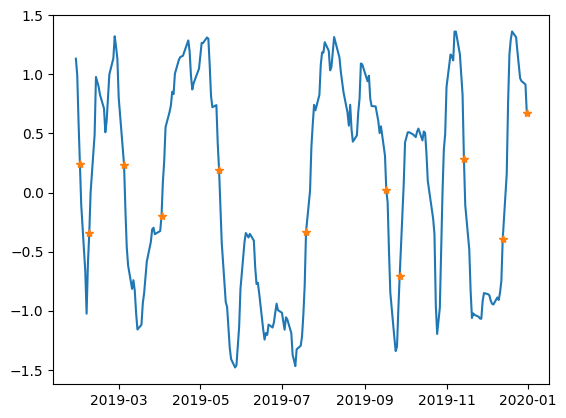

In [150]:
squareoff = zscore_spread.copy()
added = False
for i in range(len(zscore_spread)-1):
    if(pos.iloc[i] == -1 or pos.iloc[i] == 1):
        added = False
    if(zscore_spread.iloc[i]*zscore_spread.iloc[i+1] > 0 or added):
        squareoff.iloc[i] = None
    else:
        added = True

plt.plot(zscore_spread)
plt.plot(squareoff ,linestyle = 'none',marker = '*')

## Square-Off Positions Based on Z-Score Sign Change
---
In trading strategies utilizing the Z-score, it's essential to implement a mechanism for square-off positions when the Z-score changes its sign from -1 to +1, especially after initiating long or short positions. This approach ensures:

- ***Effective Risk Management:*** Square-off positions help manage risk by closing trades when market conditions potentially reverse, as indicated by the Z-score sign change.

- ***Avoiding Over-Exposure:*** It prevents over-exposure by exiting positions that might become less favorable as the market dynamics shift, thereby protecting capital.

- ***Aligning with Strategy:*** Implementing square-offs based on Z-score sign changes aligns trading decisions with strategy goals, enhancing consistency and performance.

By incorporating this mechanism, traders can optimize their trading strategies to react appropriately to market shifts indicated by the Z-score, improving overall trading outcomes.



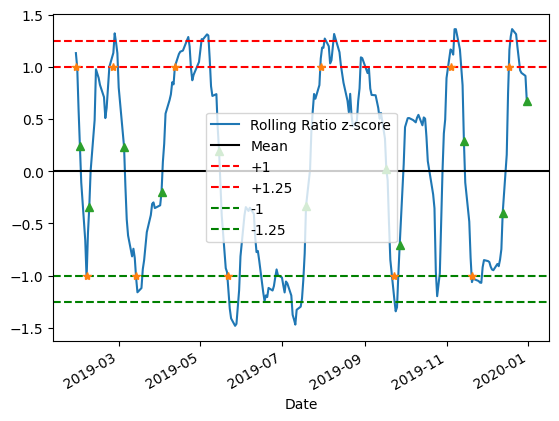

In [151]:
zscore_spread.plot()
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(1.25, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(-1.25, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-score', 'Mean', '+1','+1.25','-1','-1.25'])

plotpos = -pos
plt.plot(plotpos,linestyle = 'none',marker = '*')
plt.plot(squareoff,linestyle = 'none',marker = '^')

[[0, 3, -1], [6, 8, 1], [19, 24, -1], [31, 42, 1], [50, 69, -1], [74, 115, 1], [122, 153, -1], [157, 161, 1], [184, 191, -1], [195, 212, 1], [215, 223, -1]]


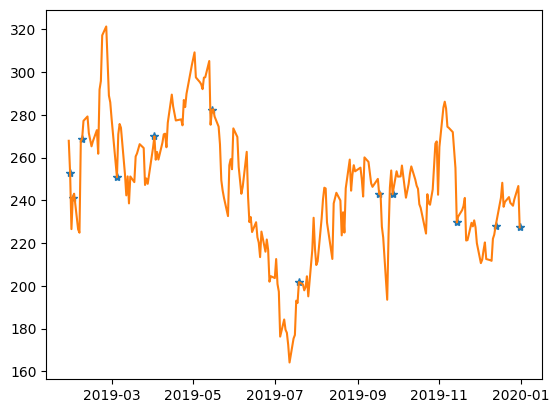

In [152]:
trades = []
currentPos = 0
startingTrade = 0
endingTrade = 0
for i in range(len(pos)):
    if pos.iloc[i] == -1:
        startingTrade = i
        currentPos = -1
    elif pos.iloc[i] == 1:
        currentPos = 1 
        startingTrade = i
    
    if squareoff.iloc[i] >= 0 or squareoff.iloc[i] <= 0:
        endingTrade = i
        trades.append([startingTrade,endingTrade,currentPos])

finalpos = fspread.copy()
for i in range(len(trades)):
    finalpos.iloc[trades[i][1]] = 0
    finalpos.iloc[trades[i][2]] = 0

for i in range(len(finalpos)):
    if(finalpos.iloc[i] == 0):
        finalpos.iloc[i] = fspread.iloc[i]
    else:
        finalpos.iloc[i] = None

plt.plot(finalpos,linestyle = 'none',marker ='*')
plt.plot(fspread)
print((trades))

## Performance Metrics for Trading Strategy

### Formulas and Metrics
---
### Sharpe Ratio

The Sharpe Ratio measures the risk-adjusted return of an investment or trading strategy.

$ \text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p} \times \sqrt{N} $

- $ R_p $: Average return of the strategy
- $ R_f $: Risk-free rate (usually taken as 0 for simplicity)
- $ \sigma_p $: Standard deviation of the strategy's returns
- $ N $: Number of trades (or periods) per year

---
### Drawdown

Drawdown measures the peak-to-trough decline during a specific period of investment or trading activity.

$ \text{Drawdown} = \frac{\text{Current Value} - \text{Peak Value}}{\text{Peak Value}} $

- **Max Drawdown**: The maximum drawdown experienced over the trading period.
---
### Returns

Returns represent the total profits or losses generated by the trading strategy.

$ \text{Returns} = \sum \text{Trade Returns} - \text{Transaction Costs} $

---
### Final Booksize

Final Booksize is the total value of the trading account after all trades are executed.

---
### Win-Loss Ratio

Win-Loss Ratio indicates the proportion of winning trades to losing trades.

$ \text{Win-Loss Ratio} = \frac{\text{Number of Wins}}{\text{Number of Losses}} $

---

## Analysis

These metrics are crucial for evaluating the effectiveness and risk management of a trading strategy. A high Sharpe Ratio indicates better risk-adjusted returns, while a low drawdown suggests consistent performance. The win-loss ratio provides insights into the strategy's success rate in generating profitable trades.

By calculating and monitoring these metrics, traders can optimize their strategies, manage risks effectively, and make 


In [153]:
# Transaction cost per trade (as a percentage of the trade value)
transaction_cost_pct = 0.001  # 0.1%

# Initialize variables to store results
booksize = 10000
booksize_ = []
trade_returns = []
transaction_costs = 0



# Calculate returns and transaction costs for each trade
for trade in trades:
    start_idx, end_idx, position = trade
    start_price = fspread.iloc[start_idx]
    end_price = fspread.iloc[end_idx]
    
    # Calculate trade return
    if position == 1:  # Buy position
        trade_return = end_price - start_price
    elif position == -1:  # Sell position
        trade_return = start_price - end_price
    
    booksize += trade_return
    booksize_.append(booksize)
    trade_returns.append(trade_return)
    
    # Calculate transaction cost for this trade
    trade_value = abs(end_price - start_price)
    trade_cost = trade_value * transaction_cost_pct * 2  # Entry and exit
    transaction_costs += trade_cost

# Calculate cumulative returns and Sharpe ratio
cumulative_returns = np.sum(trade_returns) - transaction_costs
mean_returns = np.mean(trade_returns)
std_returns = np.std(trade_returns)
sharpe_ratio = mean_returns / std_returns * np.sqrt(len(trades))  # Annualized Sharpe Ratio
ir_ratio = mean_returns/std_returns
booksize_series = pd.Series(booksize_)
running_max = booksize_series.cummax()
drawdown = (booksize_series - running_max) / running_max
max_drawdown = drawdown.min()

# Calculate win-loss ratio
wins = sum(1 for r in trade_returns if r > 0)
losses = sum(1 for r in trade_returns if r < 0)
win_loss_ratio = wins / losses if losses != 0 else float('inf')

In [154]:

print('Final value of booksize: ',booksize,(booksize-10000)/100,"%")
print(f'Cumulative Returns: {cumulative_returns}')
print(f'Sharpe Ratio: {sharpe_ratio}')
print(f'Information Ratio:{ir_ratio}')
print(f'Total Transaction Costs: {transaction_costs}')
print(f'Maximum Drawdown: {max_drawdown:.2%}')
print(f'Win-Loss Ratio: {win_loss_ratio:.2f}')

Final value of booksize:  10218.913762377533 2.189137623775332 %
Cumulative Returns: 218.16501126830624
Sharpe Ratio: 1.948292135796434
Information Ratio:0.5874321814942657
Total Transaction Costs: 0.7487511092271971
Maximum Drawdown: -0.63%
Win-Loss Ratio: 1.75


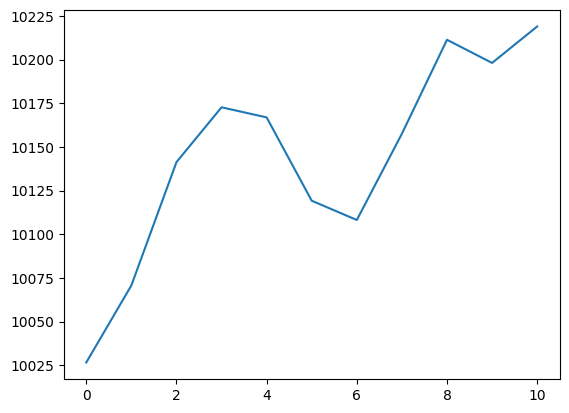

In [155]:
plt.plot(booksize_)